# FloPy

## Creating a Complex MODFLOW 6 Model with Flopy

The purpose of this notebook is to demonstrate the Flopy capabilities for building a more complex MODFLOW 6 model from scratch.  This notebook will demonstrate the capabilities by replicating the advgw_tidal model that is distributed with MODFLOW 6.

### Setup the Notebook Environment

In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_us/flopy
3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.16.2
matplotlib version: 3.0.3
flopy version: 3.2.12


In [2]:
# For this example, we will set up a model workspace.
# Model input files and output files will reside here.
model_name = 'advgw_tidal'
workspace = os.path.join('data', model_name)
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [3]:
data_pth = os.path.join('..', 'data', 'mf6', 'create_tests', 
                        'test005_advgw_tidal')
assert os.path.isdir(data_pth)

In [4]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name='mf6', 
                             sim_ws=workspace)

# create tdis package
tdis_rc = [(1.0, 1, 1.0), (10.0, 120, 1.0), 
           (10.0, 120, 1.0), (10.0, 120, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             nper=4, perioddata=tdis_rc)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=0.0001, 
                           outer_maximum=500, under_relaxation='NONE', 
                           inner_maximum=100, inner_hclose=0.0001, 
                           rcloserecord=0.001, linear_acceleration='CG', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.97)
sim.register_ims_package(ims, [gwf.name])

In [5]:
# discretization package
nlay = 3
nrow = 15
ncol = 10
botlay2 = {'factor':1.0, 'data': [-100 for x in range(150)]}
dis = flopy.mf6.ModflowGwfdis(gwf, pname='dis', nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=500.0, delc=500.0, top=50.0, 
                              botm=[5.0, -10.0, botlay2], 
                              filename='{}.dis'.format(model_name))

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=50.0,
                            filename='{}.ic'.format(model_name))

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, pname='npf', save_flows=True, 
                              icelltype=[1,0,0], 
                              k=[5.0, 0.1, 4.0],
                              k33=[0.5, 0.005, 0.1])

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbb'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), 
                                         ('BUDGET', 'LAST')])

In [6]:
# storage package
sy = flopy.mf6.ModflowGwfsto.sy.empty(gwf, layered=True)
for layer in range(0,3):
    sy[layer]['data'] = 0.2
    
ss = flopy.mf6.ModflowGwfsto.ss.empty(gwf, layered=True, default_value=0.000001)

sto = flopy.mf6.ModflowGwfsto(gwf, pname='sto', save_flows=True, iconvert=1, 
                              ss=ss, sy=sy, steady_state={0:True},
                              transient={1:True})

In [7]:
# well package
# test empty with aux vars, bound names, and time series
period_two = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=3, aux_vars=['var1', 'var2', 'var3'],
                                                         boundnames=True, timeseries=True)
period_two[0][0] = ((0,11,2), -50.0, -1, -2, -3, None)
period_two[0][1] = ((2,4,7), 'well_1_rate', 1, 2, 3, 'well_1')
period_two[0][2] = ((2,3,2), 'well_2_rate', 4, 5, 6, 'well_2')
period_three = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=2, aux_vars=['var1', 'var2', 'var3'],
                                                           boundnames=True, timeseries=True)
period_three[0][0] = ((2,3,2), 'well_2_rate', 1, 2, 3, 'well_2')
period_three[0][1] = ((2,4,7), 'well_1_rate', 4, 5, 6, 'well_1')
period_four = flopy.mf6.ModflowGwfwel.stress_period_data.empty(gwf, maxbound=5, aux_vars=['var1', 'var2', 'var3'],
                                                          boundnames=True, timeseries=True)
period_four[0][0] = ((2,4,7), 'well_1_rate', 1, 2, 3, 'well_1')
period_four[0][1] = ((2,3,2), 'well_2_rate', 4, 5, 6, 'well_2')
period_four[0][2] = ((0,11,2), -10.0, 7, 8, 9, None)
period_four[0][3] = ((0,2,4), -20.0, 17, 18, 19, None)
period_four[0][4] = ((0,13,5), -40.0, 27, 28, 29, None)
stress_period_data = {}
stress_period_data[1] = period_two[0]
stress_period_data[2] = period_three[0]
stress_period_data[3] = period_four[0]
wel = flopy.mf6.ModflowGwfwel(gwf, pname='wel', print_input=True, print_flows=True,
                              auxiliary=[('var1', 'var2', 'var3')], maxbound=5,
                              stress_period_data=stress_period_data, boundnames=True, 
                              save_flows=True)

# well ts package
ts_data =[(0.0, 0.0, 0.0, 0.0),
          (1.0, -200.0, 0.0, -100.0),
          (11.0, -1800.0, -500.0, -200.0),
          (21.0, -200.0, -400.0, -300.0),
          (31.0, 0.0, -600.0, -400.0)]
wel.ts.initialize(filename='well-rates.ts', timeseries=ts_data,
                   time_series_namerecord=[('well_1_rate', 'well_2_rate', 'well_3_rate')],
                   interpolation_methodrecord=[('stepwise', 'stepwise', 'stepwise')])

In [8]:
# Evapotranspiration
evt_period = flopy.mf6.ModflowGwfevt.stress_period_data.empty(gwf, 150, nseg=3)
for col in range(0, 10):
    for row in range(0, 15):
        evt_period[0][col*15+row] = (((0, row, col), 50.0, 0.0004, 10.0, 0.2, 0.5, 0.3, 0.1, None))
evt = flopy.mf6.ModflowGwfevt(gwf, pname='evt', print_input=True, print_flows=True, 
                              save_flows=True, maxbound=150,
                              nseg=3, stress_period_data=evt_period)

In [9]:
# General-Head Boundaries
ghb_period = {}
ghb_period_array = []
for layer, cond in zip(range(1, 3), [15.0, 1500.0]):
    for row in range(0, 15):
        ghb_period_array.append(((layer, row, 9), 'tides', cond, 'Estuary-L2'))
ghb_period[0] = ghb_period_array
ghb = flopy.mf6.ModflowGwfghb(gwf, pname='ghb', print_input=True, print_flows=True, 
                              save_flows=True, boundnames=True,
                              maxbound=30, stress_period_data=ghb_period)
ts_recarray=[]
fd = open(os.path.join(data_pth, 'tides.txt'), 'r')
for line in fd:
    line_list = line.strip().split(',')
    ts_recarray.append((float(line_list[0]), float(line_list[1])))
ghb.ts.initialize(filename='tides.ts', timeseries=ts_recarray,
                  time_series_namerecord='tides',
                  interpolation_methodrecord='linear')
obs_recarray = {'ghb_obs.csv':[('ghb-2-6-10', 'GHB', (1, 5, 9)), 
                               ('ghb-3-6-10', 'GHB', (2, 5, 9))],
                'ghb_flows.csv':[('Estuary2', 'GHB', 'Estuary-L2'), 
                                 ('Estuary3', 'GHB', 'Estuary-L3')]}
ghb.obs.initialize(filename='{}.ghb.obs'.format(model_name), digits=10, 
                   print_input=True, continuous=obs_recarray)

In [10]:
obs_recarray = {'head_obs.csv':[('h1_13_8', 'HEAD', (2, 12, 7))],
                'intercell_flow_obs1.csv':[('ICF1_1.0', 'FLOW-JA-FACE', (0, 4, 5), (0, 5, 5))],
                'head-hydrographs.csv':[('h3-13-9', 'HEAD', (2, 12, 8)),
                                        ('h3-12-8', 'HEAD', (2, 11, 7)),
                                        ('h1-4-3', 'HEAD', (0, 3, 2)),
                                        ('h1-12-3', 'HEAD', (0, 11, 2)),
                                        ('h1-13-9', 'HEAD', (0, 12, 8))]}
obs_package = flopy.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

In [11]:
# River
riv_period = {}
riv_period_array = [((0,2,0),'river_stage_1',1001.0,35.9,None),
                    ((0,3,1),'river_stage_1',1002.0,35.8,None),
                    ((0,4,2),'river_stage_1',1003.0,35.7,None),
                    ((0,4,3),'river_stage_1',1004.0,35.6,None),
                    ((0,5,4),'river_stage_1',1005.0,35.5,None),
                    ((0,5,5),'river_stage_1',1006.0,35.4,'riv1_c6'),
                    ((0,5,6),'river_stage_1',1007.0,35.3,'riv1_c7'),
                    ((0,4,7),'river_stage_1',1008.0,35.2,None),
                    ((0,4,8),'river_stage_1',1009.0,35.1,None),
                    ((0,4,9),'river_stage_1',1010.0,35.0,None),
                    ((0,9,0),'river_stage_2',1001.0,36.9,'riv2_upper'),
                    ((0,8,1),'river_stage_2',1002.0,36.8,'riv2_upper'),
                    ((0,7,2),'river_stage_2',1003.0,36.7,'riv2_upper'),
                    ((0,6,3),'river_stage_2',1004.0,36.6,None),
                    ((0,6,4),'river_stage_2',1005.0,36.5,None),
                    ((0,5,5),'river_stage_2',1006.0,36.4,'riv2_c6'),
                    ((0,5,6),'river_stage_2',1007.0,36.3,'riv2_c7'),
                    ((0,6,7),'river_stage_2',1008.0,36.2,None),
                    ((0,6,8),'river_stage_2',1009.0,36.1),
                    ((0,6,9),'river_stage_2',1010.0,36.0)]
riv_period[0] = riv_period_array
riv = flopy.mf6.ModflowGwfriv(gwf, pname='riv', print_input=True, print_flows=True, 
                              save_flows='{}.cbc'.format(model_name),
                              boundnames=True, maxbound=20, 
                              stress_period_data=riv_period)
ts_recarray=[(0.0,40.0,41.0),(1.0,41.0,41.5),
             (2.0,43.0,42.0),(3.0,45.0,42.8),
             (4.0,44.0,43.0),(6.0,43.0,43.1),
             (9.0,42.0,42.4),(11.0,41.0,41.5),
             (31.0,40.0,41.0)]
riv.ts.initialize(filename='river_stages.ts', timeseries=ts_recarray,
                  time_series_namerecord=[('river_stage_1', 'river_stage_2')],
                  interpolation_methodrecord=[('linear', 'stepwise')])
obs_recarray = {'riv_obs.csv':[('rv1-3-1', 'RIV', (0,2,0)), ('rv1-4-2', 'RIV', (0,3,1)),
                               ('rv1-5-3', 'RIV', (0,4,2)), ('rv1-5-4', 'RIV', (0,4,3)),
                               ('rv1-6-5', 'RIV', (0,5,4)), ('rv1-c6', 'RIV', 'riv1_c6'),
                               ('rv1-c7', 'RIV', 'riv1_c7'), ('rv2-upper', 'RIV', 'riv2_upper'),
                               ('rv-2-7-4', 'RIV', (0,6,3)), ('rv2-8-5', 'RIV', (0,6,4)),
                               ('rv-2-9-6', 'RIV', (0,5,5,))],
                'riv_flowsA.csv':[('riv1-3-1', 'RIV', (0,2,0)), ('riv1-4-2', 'RIV', (0,3,1)),
                                  ('riv1-5-3', 'RIV', (0,4,2))],
                'riv_flowsB.csv':[('riv2-10-1', 'RIV', (0,9,0)), ('riv-2-9-2', 'RIV', (0,8,1)),
                                  ('riv2-8-3', 'RIV', (0,7,2))]}
riv.obs.initialize(filename='{}.riv.obs'.format(model_name), digits=10,
                   print_input=True, continuous=obs_recarray)

In [12]:
# First recharge package
rch1_period = {}
rch1_period_array = []
col_range = {0:3,1:4,2:5}
for row in range(0, 15):
    if row in col_range:
        col_max = col_range[row]
    else:
        col_max = 6
    for col in range(0, col_max):
        if (row == 3 and col == 5) or (row == 2 and col == 4) or (row == 1 and col == 3) or (row == 0 and col == 2):
            mult = 0.5
        else:
            mult = 1.0
        if row == 0 and col == 0:
            bnd = 'rch-1-1'
        elif row == 0 and col == 1:
            bnd = 'rch-1-2'
        elif row == 1 and col == 2:
            bnd = 'rch-2-3'
        else:
            bnd = None
        rch1_period_array.append(((0, row, col), 'rch_1', mult, bnd))
rch1_period[0] = rch1_period_array
rch1 = flopy.mf6.ModflowGwfrch(gwf, filename='{}_1.rch'.format(model_name), 
                               pname='rch_1', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, 
                               save_flows=True, boundnames=True,
                               maxbound=84, stress_period_data=rch1_period)
ts_data =[(0.0, 0.0015), (1.0, 0.0010),
          (11.0, 0.0015),(21.0, 0.0025),
          (31.0, 0.0015)]
rch1.ts.initialize(filename='recharge_rates_1.ts', timeseries=ts_data,
                   time_series_namerecord='rch_1',
                   interpolation_methodrecord='stepwise')

In [13]:
# Second recharge package
rch2_period = {}
rch2_period_array = [((0,0,2), 'rch_2', 0.5),
                     ((0,0,3), 'rch_2', 1.0),
                     ((0,0,4), 'rch_2', 1.0),
                     ((0,0,5), 'rch_2', 1.0),
                     ((0,0,6), 'rch_2', 1.0),
                     ((0,0,7), 'rch_2', 1.0),
                     ((0,0,8), 'rch_2', 1.0),
                     ((0,0,9), 'rch_2', 0.5),
                     ((0,1,3), 'rch_2', 0.5),
                     ((0,1,4), 'rch_2', 1.0),
                     ((0,1,5), 'rch_2', 1.0),
                     ((0,1,6), 'rch_2', 1.0),
                     ((0,1,7), 'rch_2', 1.0),
                     ((0,1,8), 'rch_2', 0.5),
                     ((0,2,4), 'rch_2', 0.5),
                     ((0,2,5), 'rch_2', 1.0),
                     ((0,2,6), 'rch_2', 1.0),
                     ((0,2,7), 'rch_2', 0.5),
                     ((0,3,5), 'rch_2', 0.5),
                     ((0,3,6), 'rch_2', 0.5)]
rch2_period[0] = rch2_period_array
rch2 = flopy.mf6.ModflowGwfrch(gwf, filename='{}_2.rch'.format(model_name), 
                               pname='rch_2', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, save_flows=True,
                               maxbound=20, stress_period_data=rch2_period)
ts_data = [(0.0, 0.0016), (1.0, 0.0018),
           (11.0, 0.0019),(21.0, 0.0016),
           (31.0, 0.0018)]
rch2.ts.initialize(filename='recharge_rates_2.ts', timeseries=ts_data,
                   time_series_namerecord='rch_2',
                   interpolation_methodrecord='linear')

In [14]:
# Third recharge package
rch3_period = {}
rch3_period_array = []
col_range = {0:9,1:8,2:7}
for row in range(0, 15):
    if row in col_range:
        col_min = col_range[row]
    else:
        col_min = 6
    for col in range(col_min, 10):
        if (row == 0 and col == 9) or (row == 1 and col == 8) or (row == 2 and col == 7) or (row == 3 and col == 6):
            mult = 0.5
        else:
            mult = 1.0
        rch3_period_array.append(((0, row, col), 'rch_3', mult))
rch3_period[0] = rch3_period_array
rch3 = flopy.mf6.ModflowGwfrch(gwf, filename='{}_3.rch'.format(model_name), 
                               pname='rch_3', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, save_flows=True,
                               maxbound=54, stress_period_data=rch3_period)
ts_data=[(0.0, 0.0017),(1.0, 0.0020),(11.0, 0.0017),(21.0, 0.0018),(31.0, 0.0020)]
rch3.ts.initialize(filename='recharge_rates_3.ts', timeseries=ts_data,
                   time_series_namerecord='rch_3',
                   interpolation_methodrecord='linear')

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [15]:
# change folder to save simulation
#sim.simulation_data.mfpath.set_sim_path(run_folder)

In [16]:
# write simulation to new location
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model advgw_tidal...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package wel...
    writing package ts_0...
    writing package evt...
    writing package ghb...
    writing package ts_1...
    writing package obs_0...
    writing package head_obs...
    writing package riv...
    writing package ts_2...
    writing package obs_1...
    writing package rch_1...
    writing package ts_3...
    writing package rch_2...
    writing package ts_4...
    writing package rch_3...
    writing package ts_5...


In [17]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['advgw_tidal.nam', 'advgw_tidal.ic', 'recharge_rates_1.ts', 'advgw_tidal.sto', 'tides.ts', 'advgw_tidal.ims', 'well-rates.ts', 'advgw_tidal.ghb', 'advgw_tidal.obs', 'advgw_tidal.riv.obs', 'advgw_tidal.dis', 'advgw_tidal_1.rch', 'advgw_tidal_3.rch', 'advgw_tidal_2.rch', 'advgw_tidal.oc', 'river_stages.ts', 'advgw_tidal.wel', 'advgw_tidal.ghb.obs', 'advgw_tidal.npf', 'advgw_tidal.tdis', 'recharge_rates_2.ts', 'mfsim.nam', 'advgw_tidal.riv', 'recharge_rates_3.ts', 'advgw_tidal.evt']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [18]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 19 2019 16:46:21 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
R

 Solving:  Stress period:     3    Time step:    19
 Solving:  Stress period:     3    Time step:    20
 Solving:  Stress period:     3    Time step:    21
 Solving:  Stress period:     3    Time step:    22
 Solving:  Stress period:     3    Time step:    23
 Solving:  Stress period:     3    Time step:    24
 Solving:  Stress period:     3    Time step:    25
 Solving:  Stress period:     3    Time step:    26
 Solving:  Stress period:     3    Time step:    27
 Solving:  Stress period:     3    Time step:    28
 Solving:  Stress period:     3    Time step:    29
 Solving:  Stress period:     3    Time step:    30
 Solving:  Stress period:     3    Time step:    31
 Solving:  Stress period:     3    Time step:    32
 Solving:  Stress period:     3    Time step:    33
 Solving:  Stress period:     3    Time step:    34
 Solving:  Stress period:     3    Time step:    35
 Solving:  Stress period:     3    Time step:    36
 Solving:  Stress period:     3    Time step:    37
 Solving:  S

 Solving:  Stress period:     4    Time step:    62
 Solving:  Stress period:     4    Time step:    63
 Solving:  Stress period:     4    Time step:    64
 Solving:  Stress period:     4    Time step:    65
 Solving:  Stress period:     4    Time step:    66
 Solving:  Stress period:     4    Time step:    67
 Solving:  Stress period:     4    Time step:    68
 Solving:  Stress period:     4    Time step:    69
 Solving:  Stress period:     4    Time step:    70
 Solving:  Stress period:     4    Time step:    71
 Solving:  Stress period:     4    Time step:    72
 Solving:  Stress period:     4    Time step:    73
 Solving:  Stress period:     4    Time step:    74
 Solving:  Stress period:     4    Time step:    75
 Solving:  Stress period:     4    Time step:    76
 Solving:  Stress period:     4    Time step:    77
 Solving:  Stress period:     4    Time step:    78
 Solving:  Stress period:     4    Time step:    79
 Solving:  Stress period:     4    Time step:    80
 Solving:  S

### Post-Process Head Results

Post-processing MODFLOW 6 results is still a work in progress.  There aren't any Flopy plotting functions built in yet, like they are for other MODFLOW versions.  So we need to plot the results using general Flopy capabilities.  We can also use some of the Flopy ModelMap capabilities for MODFLOW 6, but in order to do so, we need to manually create a SpatialReference object, that is needed for the plotting.  Examples of both approaches are shown below.

First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

In [19]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
headfile = '{}.hds'.format(model_name)
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

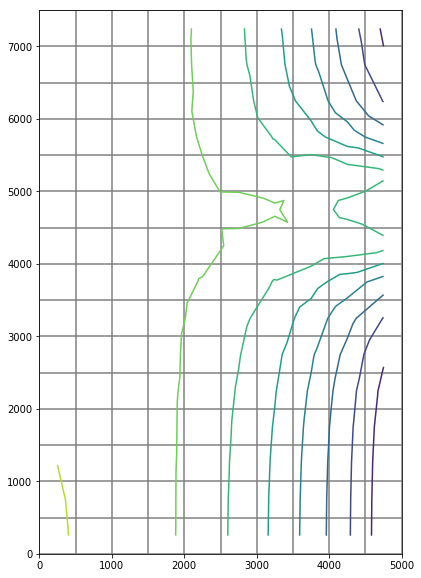

In [20]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
#quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[0])

### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using Flopy capabilities.  The MfGrdFile class in Flopy can be used to read the binary grid file.  The CellBudgetFile class in Flopy can be used to read the binary budget file written by MODFLOW 6.

In [21]:
# read the binary grid file
fname = os.path.join(workspace, '{}.dis.grb'.format(model_name))
bgf = flopy.utils.mfgrdfile.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict

OrderedDict([('NCELLS', 450),
             ('NLAY', 3),
             ('NROW', 15),
             ('NCOL', 10),
             ('NJA', 2700),
             ('XORIGIN', 0.0),
             ('YORIGIN', 0.0),
             ('ANGROT', 0.0),
             ('DELR',
              array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500.])),
             ('DELC',
              array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                     500., 500., 500., 500.])),
             ('TOP', array([[50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
                     [50., 50., 50., 50., 50., 50., 50., 50., 

In [22]:
# Information from the binary grid file is easily retrieved
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [23]:
# read the cell budget file
fname = os.path.join(workspace, '{}.cbb'.format(model_name))
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
#cbb.list_records()

flowja = cbb.get_data(text='FLOW-JA-FACE')[0][0, 0, :]

In [24]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 2; i = 7; j = 7
celln = k * nrow * ncol + i * nrow + j
print('Printing flows for cell {}'.format(celln + 1))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]  # change from one-based to zero-based
    print('Cell {} flow with cell {} is {}'.format(celln + 1, cellm + 1, flowja[ipos]))

Printing flows for cell 413
Cell 413 flow with cell 263 is 251.46262091207623
Cell 413 flow with cell 403 is 0.7176346498656017
Cell 413 flow with cell 412 is 439.8629968543804
Cell 413 flow with cell 414 is -693.4212447574185
Cell 413 flow with cell 423 is 1.3779378787739915


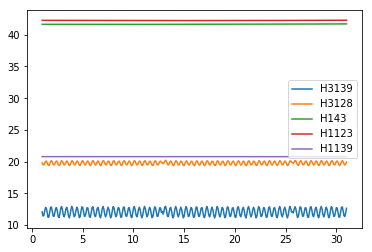

In [25]:
fname = 'head-hydrographs.csv'
fname = os.path.join(workspace, fname)
csv = np.genfromtxt(fname, delimiter=',', dtype=None, names=True)
for name in csv.dtype.names[1:]:
    plt.plot(csv['time'], csv[name], label=name)
plt.legend()